# Automated CapsnetsS2I train + test

First, import stuff

In [7]:
import model_s2i
import data_loader
import tensorflow as tf

In [8]:
import warnings
warnings.filterwarnings('ignore')
tf.logging.set_verbosity(tf.logging.ERROR)

## Load word vectors and data

In [15]:
WORD_VEC_SCENARIO = "FastText-300-verbsDatasets-synAntVSP-dia"
SCENARIO_NAME = 'vec-100-1-attention'

word2vec_path = '../../romanian_word_vecs/cleaned-vectors-diacritice-100.vec'

# No diacritics data
training_data_paths = [
#         '../data-capsnets/scenario0/train.txt',
#         '../data-capsnets/scenario1/train.txt',
#         '../data-capsnets/scenario2/train.txt',
#         '../data-capsnets/scenario3.1/train.txt',
#         '../data-capsnets/scenario3.2/train.txt',
#         '../data-capsnets/scenario3.3/train.txt',
        '../data-capsnets/diacritics/scenario0/train.txt',
        '../data-capsnets/diacritics/scenario1/train.txt',
        '../data-capsnets/diacritics/scenario2/train.txt',
        '../data-capsnets/diacritics/scenario31/train.txt',
        '../data-capsnets/diacritics/scenario32/train.txt',
        '../data-capsnets/diacritics/scenario33/train.txt',
        
    ]
test_data_paths = [
#     '../data-capsnets/scenario0/test.txt',
#     '../data-capsnets/scenario1/test.txt',
#     '../data-capsnets/scenario2/test.txt',
#     '../data-capsnets/scenario3.1/test.txt',
#     '../data-capsnets/scenario3.2/test.txt',
#     '../data-capsnets/scenario3.3/test.txt',
    '../data-capsnets/diacritics/scenario0/test.txt',
    '../data-capsnets/diacritics/scenario1/test.txt',
    '../data-capsnets/diacritics/scenario2/test.txt',
    '../data-capsnets/diacritics/scenario31/test.txt',
    '../data-capsnets/diacritics/scenario32/test.txt',
    '../data-capsnets/diacritics/scenario33/test.txt',
]

scenario_nums = [
#     '0_' + WORD_VEC_SCENARIO,
#     '1_' + WORD_VEC_SCENARIO,
#     '2_' + WORD_VEC_SCENARIO,
#     '31_' + WORD_VEC_SCENARIO,
#     '32_' + WORD_VEC_SCENARIO,
#     '33_' + WORD_VEC_SCENARIO,
#     '0_dia_' + WORD_VEC_SCENARIO,
#     '1_dia_' + WORD_VEC_SCENARIO,
#     '2_dia_' + WORD_VEC_SCENARIO,
#     '31_dia_' + WORD_VEC_SCENARIO,
#     '32_dia_' + WORD_VEC_SCENARIO,
#     '33_dia_' + WORD_VEC_SCENARIO,
    '0-' + SCENARIO_NAME,
    '1-' + SCENARIO_NAME,
    '2-' + SCENARIO_NAME,
    '31-' + SCENARIO_NAME,
    '32-' + SCENARIO_NAME,
    '33-' + SCENARIO_NAME,
]

In [19]:
print('------------------load word2vec begin-------------------')
w2v = data_loader.load_w2v(word2vec_path)
print('------------------load word2vec end---------------------')

------------------load word2vec begin-------------------
loading time took 000.03
------------------load word2vec end---------------------


# Flag setting functions + utils

In [20]:
import csv

def set_flags(data, scenario):
    FLAGS = tf.app.flags.FLAGS

    tf.app.flags.DEFINE_boolean('save_model', False, 'save model to disk')
    tf.app.flags.DEFINE_string('summaries_dir', './logs', 'tensorboard summaries')
    tf.app.flags.DEFINE_string('ckpt_dir', './saved_models/', 'check point dir')
    tf.app.flags.DEFINE_string('scenario_num', scenario, 'Scenario number')
    tf.app.flags.DEFINE_string('errors_dir', './errors/', 'Errors dir')
    tf.app.flags.DEFINE_string('results_dir', './results/', 'Results dir')
    tf.app.flags.DEFINE_string('hyperparams_dir', './hyperparams/', 'Hyperparams dir')
    
    vocab_size, word_emb_size = data['embedding'].shape
    _, max_sentence_length = data['x_tr'].shape
    intents_number = len(data['intents_dict'])
    slots_number = len(data['slots_dict'])
    hidden_size = 16

    tf.app.flags.DEFINE_float('keep_prob', 1, 'embedding dropout keep rate for training')
    tf.app.flags.DEFINE_integer('hidden_size', hidden_size, 'embedding vector size')
    tf.app.flags.DEFINE_integer('batch_size', 32, 'batch size')
    tf.app.flags.DEFINE_integer('num_epochs', 20, 'num of epochs')
    tf.app.flags.DEFINE_integer('vocab_size', vocab_size, 'vocab size of word vectors')
    tf.app.flags.DEFINE_integer('max_sentence_length', max_sentence_length, 'max number of words in one sentence')
    tf.app.flags.DEFINE_integer('intents_nr', intents_number, 'intents_number')  #
    tf.app.flags.DEFINE_integer('slots_nr', slots_number, 'slots_number')  #
    tf.app.flags.DEFINE_integer('word_emb_size', word_emb_size, 'embedding size of word vectors')
    tf.app.flags.DEFINE_boolean('use_embedding', True, 'whether to use embedding or not.')
    tf.app.flags.DEFINE_float('learning_rate', 0.01, 'learning rate')
    tf.app.flags.DEFINE_integer('slot_routing_num', 2, 'slot routing num')
    tf.app.flags.DEFINE_integer('intent_routing_num', 3, 'intent routing num')
    tf.app.flags.DEFINE_integer('intent_output_dim', 8, 'intent output dimension')
    tf.app.flags.DEFINE_integer('slot_output_dim', 2 * hidden_size, 'slot output dimension')
    tf.app.flags.DEFINE_integer('d_a', 10, 'self attention weight hidden units number')
    tf.app.flags.DEFINE_integer('r', 1, 'number of self attention heads')
    tf.app.flags.DEFINE_float('alpha', 0.0001, 'coefficient for self attention loss')
    tf.app.flags.DEFINE_integer('n_splits', 3, 'Number of cross-validation splits')
    tf.app.flags.DEFINE_float('rerouting_coef', 0.5, 'coefficient for rerouting')
    tf.app.flags.DEFINE_boolean('use_rerouting', True, 'whether to use rerouting or not')
    tf.app.flags.DEFINE_boolean('use_attention', True,
                                'whether to use attention or not. If attention is used,'
                                'slot_output_dim will be overridden to hidden_size * 2')
    
    tf.app.flags.DEFINE_string('f', '', 'kernel') # Without this there's an error: unknown command line flag 'f'
    
    return FLAGS

def del_all_flags(FLAGS):
    flags_dict = FLAGS._flags()
    keys_list = [keys for keys in flags_dict]
    for keys in keys_list:
        FLAGS.__delattr__(keys)
        
def write_csv(run_results):
    with open('results/results_{}.csv'.format(SCENARIO_NAME), 'w') as f:
        header_line = ['Scenario', 'Intent F1', 'Slot F1']
        writer = csv.writer(f)
        writer.writerow(header_line)
        for k, v in run_results.items():
            scenario_num = [k]
            intent_score = [v['intent_f1']]
            slot_score = [v['slot_f1']]
            l = scenario_num + intent_score + slot_score
            writer.writerow(l)

In [22]:
# In case it's needed
del_all_flags(FLAGS)

------------------read datasets begin-------------------
max length is 15
max length is 15
------------------read datasets end---------------------
TRAINING 0-vec-100-1-attention
------------------start cross-validation-------------------
FOLD 1
Initializing Variables
using pre-trained word emebedding.begin...
using pre-trained word emebedding.ended...
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.073810
F score 0.073810
Slot filling
F1 score: 0.017703
Accuracy: 0.134603
------------------epoch :  0  Loss:  31.082188 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.161905
F score 0.161905
Slot filling
F1 score: 0.066860
Accuracy: 0.882857
Current F score mean 0.11438261351052048
Best F score mean 0.11438261351052048
------------------epoch :  1  Loss:  21.108679 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.280952
F score 0.280952
Slot fill

------------------epoch :  5  Loss:  2.2847753 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.695238
F score 0.695238
Slot filling
F1 score: 0.761722
Accuracy: 0.976032
Current F score mean 0.7284802916381863
Best F score mean 0.9806562726613488
------------------epoch :  6  Loss:  1.0192802 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.740476
F score 0.740476
Slot filling
F1 score: 0.818805
Accuracy: 0.984286
Current F score mean 0.7796406417611119
Best F score mean 0.9806562726613488
------------------epoch :  7  Loss:  0.95643795 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.769048
F score 0.769048
Slot filling
F1 score: 0.889332
Accuracy: 0.990000
Current F score mean 0.8291898115178274
Best F score mean 0.9806562726613488
------------------epoch :  8  Loss:  0.5857873 ----------------------
           VALIDATIO

           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.914286
F score 0.914286
Slot filling
F1 score: 0.977688
Accuracy: 0.998413
Current F score mean 0.9459866705302811
Best F score mean 0.9806562726613488
------------------epoch :  12  Loss:  0.36884192 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.919048
F score 0.919048
Slot filling
F1 score: 0.990844
Accuracy: 0.999048
Current F score mean 0.9549459865329651
Best F score mean 0.9806562726613488
------------------epoch :  13  Loss:  0.0691587 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.945238
F score 0.945238
Slot filling
F1 score: 0.986802
Accuracy: 0.998571
Current F score mean 0.966020062847474
Best F score mean 0.9806562726613488
------------------epoch :  14  Loss:  0.024724547 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.96666

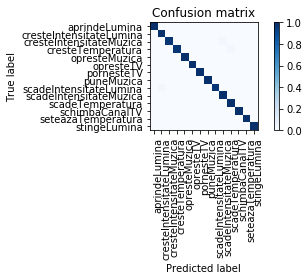

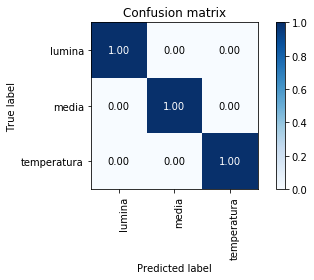

Intent F1: 0.994643
Slot F1: 0.990840
------------------read datasets begin-------------------
max length is 14
max length is 14
------------------read datasets end---------------------
TRAINING 1-vec-100-1-attention
------------------start cross-validation-------------------
FOLD 1
Initializing Variables
using pre-trained word emebedding.begin...
using pre-trained word emebedding.ended...
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.071429
F score 0.071429
Slot filling
F1 score: 0.015428
Accuracy: 0.152551
------------------epoch :  0  Loss:  29.280735 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.157143
F score 0.157143
Slot filling
F1 score: 0.122786
Accuracy: 0.876531
Current F score mean 0.13996458087367178
Best F score mean 0.13996458087367178
------------------epoch :  1  Loss:  22.600748 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accura

------------------epoch :  5  Loss:  4.1774955 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.745238
F score 0.745238
Slot filling
F1 score: 0.887129
Accuracy: 0.989286
Current F score mean 0.8161834040546911
Best F score mean 0.9785207700101317
------------------epoch :  6  Loss:  2.0808563 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.816667
F score 0.816667
Slot filling
F1 score: 0.921860
Accuracy: 0.992177
Current F score mean 0.8692631058358062
Best F score mean 0.9785207700101317
------------------epoch :  7  Loss:  1.2240456 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.842857
F score 0.842857
Slot filling
F1 score: 0.941410
Accuracy: 0.994898
Current F score mean 0.8921336359767342
Best F score mean 0.9785207700101317
------------------epoch :  8  Loss:  0.6611569 ----------------------
           VALIDATION

           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.989055
Accuracy: 0.998639
Current F score mean 0.9945273631840795
Best F score mean 0.9945273631840795
------------------epoch :  12  Loss:  0.016807247 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.990060
Accuracy: 0.998810
Current F score mean 0.9950298210735586
Best F score mean 0.9950298210735586
------------------epoch :  13  Loss:  0.012529296 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.990060
Accuracy: 0.998810
Current F score mean 0.9950298210735586
Best F score mean 0.9950298210735586
------------------epoch :  14  Loss:  0.010596584 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.0

<Figure size 432x288 with 0 Axes>

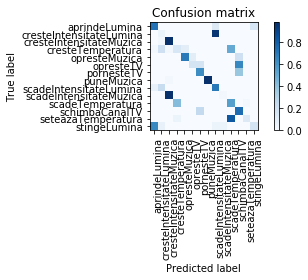

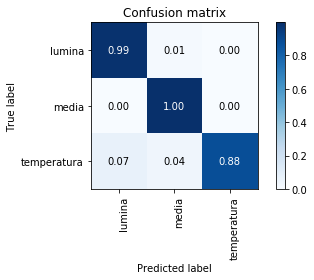

Intent F1: 0.478571
Slot F1: 0.768668
------------------read datasets begin-------------------
max length is 14
max length is 14
------------------read datasets end---------------------
TRAINING 2-vec-100-1-attention
------------------start cross-validation-------------------
FOLD 1
Initializing Variables
using pre-trained word emebedding.begin...
using pre-trained word emebedding.ended...
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.083333
F score 0.083333
Slot filling
F1 score: 0.013289
Accuracy: 0.007738
------------------epoch :  0  Loss:  33.6278 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.172222
F score 0.172222
Slot filling
F1 score: 0.164425
Accuracy: 0.878968
Current F score mean 0.1683233682112606
Best F score mean 0.1683233682112606
------------------epoch :  1  Loss:  21.781065 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0

------------------epoch :  5  Loss:  2.1867332 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.897222
F score 0.897222
Slot filling
F1 score: 0.936475
Accuracy: 0.993849
Current F score mean 0.9168488160291439
Best F score mean 0.998416050686378
------------------epoch :  6  Loss:  1.2154663 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.941667
F score 0.941667
Slot filling
F1 score: 0.956879
Accuracy: 0.995833
Current F score mean 0.9492727583846681
Best F score mean 0.998416050686378
------------------epoch :  7  Loss:  0.94799435 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.958333
F score 0.958333
Slot filling
F1 score: 0.933196
Accuracy: 0.993651
Current F score mean 0.9457648167180541
Best F score mean 0.998416050686378
------------------epoch :  8  Loss:  0.27532515 ----------------------
           VALIDATION 

           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.997963
Accuracy: 0.999405
Current F score mean 0.9989816700610998
Best F score mean 0.9989816700610998
------------------epoch :  12  Loss:  0.030690009 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.997963
Accuracy: 0.999405
Current F score mean 0.9989816700610998
Best F score mean 0.9989816700610998
------------------epoch :  13  Loss:  0.024771458 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.000000
F score 1.000000
Slot filling
F1 score: 0.997963
Accuracy: 0.999405
Current F score mean 0.9989816700610998
Best F score mean 0.9989816700610998
------------------epoch :  14  Loss:  0.020535681 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 1.0

<Figure size 432x288 with 0 Axes>

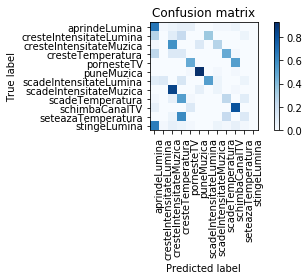

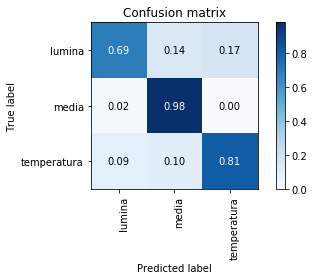

Intent F1: 0.377083
Slot F1: 0.536220
------------------read datasets begin-------------------
max length is 14
max length is 14
------------------read datasets end---------------------
TRAINING 31-vec-100-1-attention
------------------start cross-validation-------------------
FOLD 1
Initializing Variables
using pre-trained word emebedding.begin...
using pre-trained word emebedding.ended...
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.009615
F score 0.009615
Slot filling
F1 score: 0.024414
Accuracy: 0.100504
------------------epoch :  0  Loss:  31.42212 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.185897
F score 0.185897
Slot filling
F1 score: 0.058511
Accuracy: 0.885989
Current F score mean 0.12220403709765414
Best F score mean 0.12220403709765414
------------------epoch :  1  Loss:  20.724548 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accura

------------------epoch :  5  Loss:  2.7759833 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.842949
F score 0.842949
Slot filling
F1 score: 0.718310
Accuracy: 0.960852
Current F score mean 0.7806292885518238
Best F score mean 0.9769917582417582
------------------epoch :  6  Loss:  2.6549315 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.907051
F score 0.907051
Slot filling
F1 score: 0.880355
Accuracy: 0.991071
Current F score mean 0.8937028936105746
Best F score mean 0.9769917582417582
------------------epoch :  7  Loss:  1.8060102 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.939103
F score 0.939103
Slot filling
F1 score: 0.945783
Accuracy: 0.994963
Current F score mean 0.9424428483163423
Best F score mean 0.9769917582417582
------------------epoch :  8  Loss:  0.94143784 ----------------------
           VALIDATIO

           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.974359
F score 0.974359
Slot filling
F1 score: 0.949254
Accuracy: 0.994505
Current F score mean 0.961806352851129
Best F score mean 0.986896681749623
------------------epoch :  12  Loss:  0.06484671 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.977564
F score 0.977564
Slot filling
F1 score: 0.965620
Accuracy: 0.995650
Current F score mean 0.9715922157065655
Best F score mean 0.986896681749623
------------------epoch :  13  Loss:  0.045019507 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.977564
F score 0.977564
Slot filling
F1 score: 0.964286
Accuracy: 0.996566
Current F score mean 0.9709249084249085
Best F score mean 0.986896681749623
------------------epoch :  14  Loss:  0.03922185 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.980769


<Figure size 432x288 with 0 Axes>

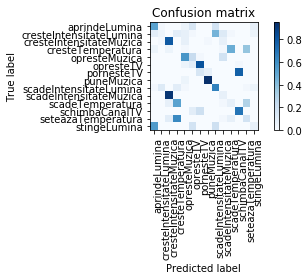

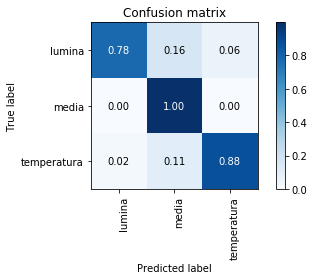

Intent F1: 0.350000
Slot F1: 0.570743
------------------read datasets begin-------------------
max length is 14
max length is 14
------------------read datasets end---------------------
TRAINING 32-vec-100-1-attention
------------------start cross-validation-------------------
FOLD 1
Initializing Variables
using pre-trained word emebedding.begin...
using pre-trained word emebedding.ended...
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.088496
F score 0.088496
Slot filling
F1 score: 0.014960
Accuracy: 0.213864
------------------epoch :  0  Loss:  27.773542 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.112094
F score 0.112094
Slot filling
F1 score: 0.148936
Accuracy: 0.932153
Current F score mean 0.13051528274650098
Best F score mean 0.13051528274650098
------------------epoch :  1  Loss:  17.912907 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accur

------------------epoch :  5  Loss:  2.1414993 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.849558
F score 0.849558
Slot filling
F1 score: 0.862069
Accuracy: 0.986515
Current F score mean 0.8558132438205676
Best F score mean 0.974661296875276
------------------epoch :  6  Loss:  0.83873934 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.905605
F score 0.905605
Slot filling
F1 score: 0.889590
Accuracy: 0.989465
Current F score mean 0.8975973125633939
Best F score mean 0.974661296875276
------------------epoch :  7  Loss:  0.40816617 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.961652
F score 0.961652
Slot filling
F1 score: 0.900154
Accuracy: 0.989886
Current F score mean 0.9309027636175795
Best F score mean 0.974661296875276
------------------epoch :  8  Loss:  0.22175579 ----------------------
           VALIDATION

           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.982301
F score 0.982301
Slot filling
F1 score: 0.950525
Accuracy: 0.994100
Current F score mean 0.9664128112934683
Best F score mean 0.980212942477876
------------------epoch :  12  Loss:  0.10735107 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.988201
F score 0.988201
Slot filling
F1 score: 0.956522
Accuracy: 0.994943
Current F score mean 0.9723611645504682
Best F score mean 0.980212942477876
------------------epoch :  13  Loss:  0.16795212 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.985251
F score 0.985251
Slot filling
F1 score: 0.971342
Accuracy: 0.995365
Current F score mean 0.9782965602851079
Best F score mean 0.980212942477876
------------------epoch :  14  Loss:  0.33776373 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.988201


<Figure size 432x288 with 0 Axes>

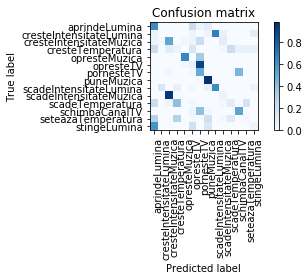

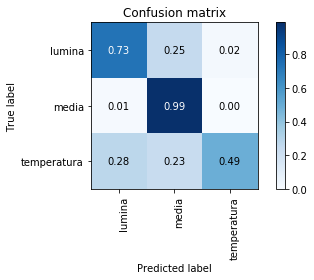

Intent F1: 0.341071
Slot F1: 0.531646
------------------read datasets begin-------------------
max length is 14
max length is 14
------------------read datasets end---------------------
TRAINING 33-vec-100-1-attention
------------------start cross-validation-------------------
FOLD 1
Initializing Variables
using pre-trained word emebedding.begin...
using pre-trained word emebedding.ended...
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.129870
F score 0.129870
Slot filling
F1 score: 0.013082
Accuracy: 0.058442
------------------epoch :  0  Loss:  34.265533 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.229437
F score 0.229437
Slot filling
F1 score: 0.100000
Accuracy: 0.851886
Current F score mean 0.1647186147186147
Best F score mean 0.1647186147186147
------------------epoch :  1  Loss:  27.46785 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy

------------------epoch :  5  Loss:  9.2715 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.666667
F score 0.666667
Slot filling
F1 score: 0.823841
Accuracy: 0.980519
Current F score mean 0.7452538631346578
Best F score mean 0.980261658932019
------------------epoch :  6  Loss:  6.4176416 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.735931
F score 0.735931
Slot filling
F1 score: 0.875000
Accuracy: 0.985467
Current F score mean 0.8054653679653678
Best F score mean 0.980261658932019
------------------epoch :  7  Loss:  5.2051816 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.779221
F score 0.779221
Slot filling
F1 score: 0.938272
Accuracy: 0.992270
Current F score mean 0.8587461920795254
Best F score mean 0.980261658932019
------------------epoch :  8  Loss:  4.7662363 ----------------------
           VALIDATION SET P

           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.956710
F score 0.956710
Slot filling
F1 score: 0.932600
Accuracy: 0.992270
Current F score mean 0.9446548408033966
Best F score mean 0.982970592625765
------------------epoch :  12  Loss:  1.1638232 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.978355
F score 0.978355
Slot filling
F1 score: 0.963889
Accuracy: 0.993816
Current F score mean 0.9711219336219337
Best F score mean 0.982970592625765
------------------epoch :  13  Loss:  0.90266716 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.987013
F score 0.987013
Slot filling
F1 score: 0.969529
Accuracy: 0.995980
Current F score mean 0.9782710364427816
Best F score mean 0.982970592625765
------------------epoch :  14  Loss:  0.5595294 ----------------------
           VALIDATION SET PERFORMANCE        
Intent detection
Intent accuracy 0.987013
F 

<Figure size 432x288 with 0 Axes>

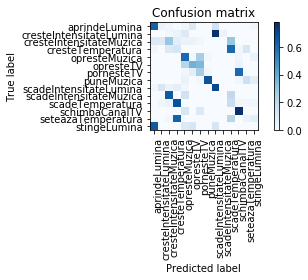

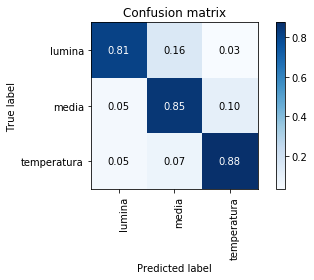

Intent F1: 0.332737
Slot F1: 0.463768


<Figure size 432x288 with 0 Axes>

In [23]:
import train
import test

results = dict()
for i in range(len(training_data_paths)):
    
    # Load data
    isLowercase = True # When using the new 100-dim word vec model, the data should all be in lowercase
    data = data_loader.read_datasets(w2v, training_data_paths[i], test_data_paths[i], test=True, lowercase=isLowercase)
    
    FLAGS = set_flags(data, scenario=scenario_nums[i])
    
    # Train model
    print('TRAINING ' + scenario_nums[i])
    train.train(model_s2i.CapsNetS2I, data, FLAGS, batches_rand=False)
    
    # Test model
    print('TESTING ' + scenario_nums[i])
    intent_f, slot_f = test.test(model_s2i.CapsNetS2I, data, FLAGS)
    results[scenario_nums[i]] = dict()
    results[scenario_nums[i]]['intent_f1'] = intent_f
    results[scenario_nums[i]]['slot_f1'] = slot_f
        
    # Reset flags
    del_all_flags(FLAGS)

write_csv(results)